In [1]:
import pickle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu

In [2]:
from nltk.translate.bleu_score import sentence_bleu

In [3]:
data = pickle.load(open('../input/flickr8k-image-feature-extraction-using-vgg16/features.pickle', 'rb'))

In [4]:
split_size = 0.8
X_train = []
Y_train = []
for img in tqdm(list(data.keys())[:int(split_size * len(data))]):
    if img == 'image': continue
    for caption in data[img]['caption']:
        X_train.append(data[img]['feature'])
        caption = f'<start> {caption} <end>'
        Y_train.append(caption)

X_test = []
Y_test = []
for img in tqdm(list(data.keys())[int(split_size * len(data)) :]):
    if img == 'image': continue
    X_test.append(img)
    Y_test.append(data[img]['caption'])

100%|██████████| 1619/1619 [00:00<00:00, 556057.83it/s]


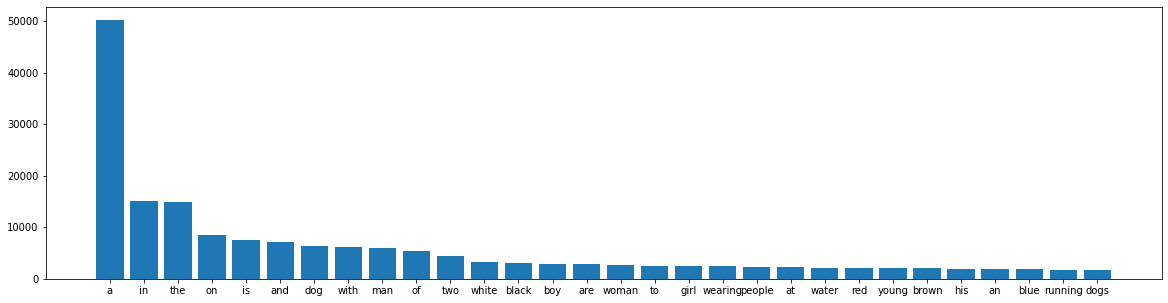

In [5]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k,
                                                  oov_token = '<unk>',
                                                  filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(Y_train)
pad_token = '<pad>'
tokenizer.word_index[pad_token] = 0

tokenizer.index_word[0] = pad_token
vals = sorted(tokenizer.word_counts.items(),key=lambda x:x[1],reverse=True)
words = [x[0] for x in vals[:32] if x[0] not in ['<start>','<end>']]
cnts = [x[1] for x in vals[:32] if x[0] not in ['<start>','<end>']]
plt.figure(figsize=(20,5))
f = plt.bar(words,cnts)

In [6]:
txt_seqs = tokenizer.texts_to_sequences(Y_train)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(txt_seqs, padding='post')

In [7]:
print(data[list(data.keys())[1]])

{'image': array([[[ -67.68     ,  -61.779    ,  -30.939003 ],
        [ -17.68     ,    6.2210007,   13.060997 ],
        [   5.3199997,   32.221    ,   34.060997 ],
        ...,
        [-118.68     , -116.779    ,  -99.939    ],
        [-118.68     , -111.779    ,  -98.939    ],
        [-120.68     , -108.779    , -101.939    ]],

       [[ -72.68     ,  -68.779    ,  -36.939003 ],
        [ -13.68     ,    9.221001 ,   21.060997 ],
        [   8.32     ,   37.221    ,   38.060997 ],
        ...,
        [-113.68     , -104.779    ,  -94.939    ],
        [-116.68     , -108.779    ,  -93.939    ],
        [-102.68     ,  -86.779    ,  -90.939    ]],

       [[ -76.68     ,  -74.779    ,  -39.939003 ],
        [  -9.68     ,   13.221001 ,   26.060997 ],
        [   6.3199997,   36.221    ,   41.060997 ],
        ...,
        [-115.68     , -107.779    ,  -99.939    ],
        [-121.68     , -107.779    , -101.939    ],
        [-123.68     , -101.779    ,  -95.939    ]],

       ..

(None, 7762)


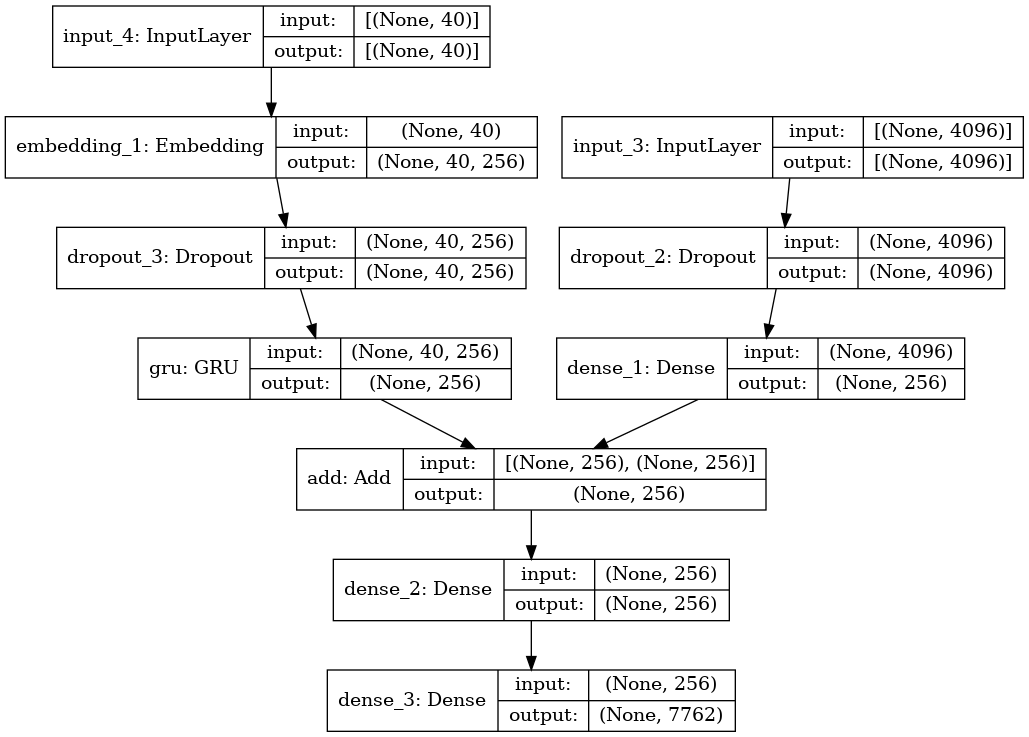

In [9]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, RNN, GRU
import numpy as np

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in Y_train)

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
print(outputs.shape)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [10]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, data, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = data[key]['caption']
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([f'<start> {caption} <end>'])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(data[key]['feature'][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
#                 print(X1.shape, X2.shape, y.shape)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [11]:
epochs = 15
batch_size = 64
steps = len(data.keys()) // batch_size

for i in range(epochs):
    generator = data_generator(list(data.keys())[1:int(len(data) * split_size)], data, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

2022-04-13 14:02:15.215870: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 64520192 exceeds 10% of free system memory.
2022-04-13 14:02:15.308961: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122267024 exceeds 10% of free system memory.
2022-04-13 14:02:15.564993: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-13 14:02:18.322985: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 64520192 exceeds 10% of free system memory.
2022-04-13 14:02:18.369334: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122267024 exceeds 10% of free system memory.
2022-04-13 14:02:19.159990: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 61145088 exceeds 10% of free system memory.


126/126 [==============================] - 71s 561ms/step - loss: 1.9805


In [12]:
model.save("vggnet_gru")

2022-04-13 14:24:29.262047: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt

BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = '<start>'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == '<end>':
            break
    return in_text

def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
#     image = Image.open(img_path)
    captions = data[image_name]['caption']
#     print('---------------------Actual---------------------')
#     for caption in captions:
#         print(caption)
#     # predict the caption
    y_pred = predict_caption(model, data[image_name]['feature'], tokenizer, max_length)
#     print('--------------------Predicted--------------------')
    print(y_pred)
#     plt.imshow(image)
    return y_pred

In [ ]:
generate_caption("1015118661_980735411b.jpg")

In [ ]:
def score(X_test, Y_test):
    bleu_score = [0,0,0,0]
    for i in tqdm(range(len(X_test))):
        predicted = generate_caption(X_test[i])
        bleu_score[0] += sentence_bleu([list(actual.split()) for actual in Y_test[i]], list(predicted.split()), weights=(1,0,0,0))
        bleu_score[1] += sentence_bleu([list(actual.split()) for actual in Y_test[i]], list(predicted.split()), weights=(0.5, 0.5, 0, 0))
        bleu_score[2] += sentence_bleu([list(actual.split()) for actual in Y_test[i]], list(predicted.split()), weights=(0.33, 0.33, 0.33, 0))
        bleu_score[3] += sentence_bleu([list(actual.split()) for actual in Y_test[i]], list(predicted.split()), weights=(0.25, 0.25, 0.25, 0.25))
    return np.array(bleu_score)/len(X_test)

In [ ]:
bleu_scores = score(X_test, Y_test)

In [ ]:
bleu_scores